**DYNAMIC PROTEIN LOCALIZATION**

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [102]:
file_path = 'StaticData.txt'
# Column names initialisation
vec = [
    "orfid", "yORF", "gene name", "GFP tagged", "GFP visualized?", "TAP visualized?", 
    "abundance", "error", "localization summary", "ambiguous", "mitochondrion", 
    "vacuole", "spindle pole", "cell periphery", "punctate composite", 
    "vacuolar membrane", "ER", "nuclear periphery", "endosome", "bud neck", 
    "microtubule", "Golgi", "late Golgi", "peroxisome", "actin", "nucleolus", 
    "cytoplasm", "ER to Golgi", "early Golgi", "lipid particle", "nucleus", "bud"
]

# Load dataset
static_data = pd.read_csv(file_path, delimiter='\t', header=None, index_col=None, skipinitialspace=True)
# Last two columns are tabs
static_data = static_data.iloc[:, :-2]
# Set column names
static_data.columns = vec

We start working on the STATIC DATA

In [103]:
# Check dataset
static_data

,orfid,yORF,gene name,GFP tagged,GFP visualized?,TAP visualized?,abundance,error,localization summary,ambiguous,...,late Golgi,peroxisome,actin,nucleolus,cytoplasm,ER to Golgi,early Golgi,lipid particle,nucleus,bud
0,206,YAL001C,TFC3,tagged,visualized,TAP visualized,125,NaN,"cytoplasm,nucleus",F,...,F,F,F,F,T,F,F,F,T,F
1,5281,YAL002W,VPS8,tagged,visualized,TAP visualized,736,NaN,endosome,F,...,F,F,F,F,F,F,F,F,F,F
2,1073,YAL005C,SSA1,tagged,visualized,TAP visualized,269000,NaN,cytoplasm,F,...,F,F,F,F,T,F,F,F,F,F
3,6096,YAL007C,ERP2,tagged,visualized,TAP visualized,26300,NaN,ER,F,...,F,F,F,F,F,F,F,F,F,F
4,3882,YAL008W,FUN14,tagged,visualized,TAP visualized,1920,NaN,mitochondrion,F,...,F,F,F,F,F,F,F,F,F,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6229,4500,YPR200C,ARR2,tagged,not visualized,not TAP visualized,not visualized,NaN,NaN,F,...,F,F,F,F,F,F,F,F,F,F
6230,5814,YPR201W,ARR3,tagged,not visualized,not TAP visualized,not visualized,NaN,NaN,F,...,F,F,F,F,F,F,F,F,F,F
6231,3172,YPR202W,NaN,tagged,not visualized,not TAP visualized,not visualized,NaN,NaN,F,...,F,F,F,F,F,F,F,F,F,F
6232,5012,YPR203W,NaN,tagged,not visualized,not TAP visualized,not visualized,NaN,NaN,F,...,F,F,F,F,F,F,F,F,F,F


In [104]:
# TO BE ASKED: what is error column? Is it usefull? (lot of nans in it)
print(np.sum(static_data["error"].isna()))
# TO BE ASKED: We have 2078 proteins untracked....
print(np.sum(static_data["localization summary"].isna()))

6028
2078


CHIEDERE:

- Quando l'errore è nan, cioè cosa rappresenta

- Cosa significano alcune colonne del dataset statico


In [105]:
# Handle fasta file with protein sequences and their identifier
def parse_fasta(file_path):
    results = []

    with open(file_path, 'r') as file:
        identifier = None
        sequence = ""
        
        for line in file:
            line = line.strip()
            
            if line.startswith(">"):
                # Salva i dati della sequenza precedente se ci sono
                if identifier and sequence:
                    results.append((identifier, sequence))
                
                # Reset per la nuova sequenza
                identifier = line.split()[0][1:]  # Prima parola dopo ">"
                sequence = ""
            
            else:
                # Accumula la sequenza di lettere
                sequence += line
        
        # Salva l'ultima sequenza
        if identifier and sequence:
            results.append((identifier, sequence))
    
    return results

# Usa il percorso al tuo file .fasta
file_path = 'orf_trans_all.fasta'
parsed_data = parse_fasta(file_path)
 
# we create a table   
proteins = pd.DataFrame(parsed_data, columns=["Identifier", "Sequence"])
print(proteins.shape)


(6723, 2)


Trying to map input (sequence) and output (location): checking missing variables

In [106]:
# Check correspondence input-output (with identifiers)
vec = static_data["yORF"].isin(proteins["Identifier"]).astype(int).values
print(vec.shape)
print(np.sum(vec))
vec_not_present = static_data.loc[vec == 0, "yORF"].values
print(vec_not_present)

(6234,)
6212
['YAR044W' 'YBR100W' 'YDR474C' 'YFL006W' 'YFR024C' 'YGL046W' 'YGR272C'
 'YJL012C-A' 'YJL017W' 'YJL018W' 'YJL021C' 'YPR090W' 'YAR061W' 'YAR062W'
 'YBR075W' 'YDL038C' 'YER186W-A' 'YFL043C' 'YIR044C' 'YKL003W-A' 'YKL199C'
 'YOR088W']


In [107]:
# Merge static_data with proteins to add the protein sequences
static_data_with_sequences = static_data.merge(proteins, left_on='yORF', right_on='Identifier', how='left')

# Drop the redundant 'Identifier' column
static_data_with_sequences.drop(columns=['Identifier'], inplace=True)

# Rename the 'Sequence' column to 'Protein Sequence'
static_data_with_sequences.rename(columns={'Sequence': 'Protein Sequence'}, inplace=True)

# Display the updated dataframe
static_data_with_sequences

,orfid,yORF,gene name,GFP tagged,GFP visualized?,TAP visualized?,abundance,error,localization summary,ambiguous,...,peroxisome,actin,nucleolus,cytoplasm,ER to Golgi,early Golgi,lipid particle,nucleus,bud,Protein Sequence
0,206,YAL001C,TFC3,tagged,visualized,TAP visualized,125,NaN,"cytoplasm,nucleus",F,...,F,F,F,T,F,F,F,T,F,MVLTIYPDELVQIVSDKIASNKGKITLNQLWDISGKYFDLSDKKVK...
1,5281,YAL002W,VPS8,tagged,visualized,TAP visualized,736,NaN,endosome,F,...,F,F,F,F,F,F,F,F,F,MEQNGLDHDSRSSIDTTINDTQKTFLEFRSYTQLSEKLASSSSYTA...
2,1073,YAL005C,SSA1,tagged,visualized,TAP visualized,269000,NaN,cytoplasm,F,...,F,F,F,T,F,F,F,F,F,MSKAVGIDLGTTYSCVAHFANDRVDIIANDQGNRTTPSFVAFTDTE...
3,6096,YAL007C,ERP2,tagged,visualized,TAP visualized,26300,NaN,ER,F,...,F,F,F,F,F,F,F,F,F,MIKSTIALPSFFIVLILALVNSVAASSSYAPVAISLPAFSKECLYY...
4,3882,YAL008W,FUN14,tagged,visualized,TAP visualized,1920,NaN,mitochondrion,F,...,F,F,F,F,F,F,F,F,F,MTLAFNMQRLVFRNLNVGKRMFKNVPLWRFNVANKLGKPLTRSVGL...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6229,4500,YPR200C,ARR2,tagged,not visualized,not TAP visualized,not visualized,NaN,NaN,F,...,F,F,F,F,F,F,F,F,F,MVSFITSRQLKGLIENQRKDFQVVDLRREDFARDHITNAWHVPVTA...
6230,5814,YPR201W,ARR3,tagged,not visualized,not TAP visualized,not visualized,NaN,NaN,F,...,F,F,F,F,F,F,F,F,F,MSEDQKSENSVPSKVNMVNRTDILTTIKSLSWLDLMLPFTIILSII...
6231,3172,YPR202W,NaN,tagged,not visualized,not TAP visualized,not visualized,NaN,NaN,F,...,F,F,F,F,F,F,F,F,F,MEIENEQICTCIAQILHLLNSLIITFSDDDKTETGQSFVYIDGFLV...
6232,5012,YPR203W,NaN,tagged,not visualized,not TAP visualized,not visualized,NaN,NaN,F,...,F,F,F,F,F,F,F,F,F,MRTFTDFVSGAPIVRSLQKSTIRKYGYNLAPHMFLLLHVDELSIFS...


In [108]:
# Drop proteins without location (i.e. with all falses and localisation_summary nan)
static_data_sq = static_data_with_sequences.dropna(subset=['localization summary'])

We delete the irrelevant columns:

In [109]:
static_data_sq = static_data_sq.iloc[:, [1] + list(range(9, static_data_with_sequences.shape[1]))]
static_data_sq

,yORF,ambiguous,mitochondrion,vacuole,spindle pole,cell periphery,punctate composite,vacuolar membrane,ER,nuclear periphery,...,peroxisome,actin,nucleolus,cytoplasm,ER to Golgi,early Golgi,lipid particle,nucleus,bud,Protein Sequence
0,YAL001C,F,F,F,F,F,F,F,F,F,...,F,F,F,T,F,F,F,T,F,MVLTIYPDELVQIVSDKIASNKGKITLNQLWDISGKYFDLSDKKVK...
1,YAL002W,F,F,F,F,F,F,F,F,F,...,F,F,F,F,F,F,F,F,F,MEQNGLDHDSRSSIDTTINDTQKTFLEFRSYTQLSEKLASSSSYTA...
2,YAL005C,F,F,F,F,F,F,F,F,F,...,F,F,F,T,F,F,F,F,F,MSKAVGIDLGTTYSCVAHFANDRVDIIANDQGNRTTPSFVAFTDTE...
3,YAL007C,F,F,F,F,F,F,F,T,F,...,F,F,F,F,F,F,F,F,F,MIKSTIALPSFFIVLILALVNSVAASSSYAPVAISLPAFSKECLYY...
4,YAL008W,F,T,F,F,F,F,F,F,F,...,F,F,F,F,F,F,F,F,F,MTLAFNMQRLVFRNLNVGKRMFKNVPLWRFNVANKLGKPLTRSVGL...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4155,YPR187W,F,F,F,F,F,F,F,F,F,...,F,F,F,T,F,F,F,T,F,MSDYEEAFNDGNENFEDFDVEHFSDEETYEEKPQFKDGETTDANGK...
4156,YPR188C,F,F,F,F,F,F,F,F,F,...,F,F,F,F,F,F,F,F,F,MDHSESLTFNQLTQDYINKLKDAFQMLDEDEDGLISRGDLTKIYAT...
4157,YPR189W,F,F,F,F,F,F,F,F,F,...,F,F,F,T,F,F,F,F,F,MSDIKQLLKEAKQELTNRDYEETIEISEKVLKLDPDNYFAHIFLGK...
4158,YPR190C,F,F,F,F,F,F,F,F,F,...,F,F,F,T,F,F,F,T,F,MDELLGEALSAENQTGESTVESEKLVTPEDVMTISSLEQRTLNPDL...


In [110]:
# Drop proteins without sequence
static_data_sq = static_data_sq.dropna(subset=['Protein Sequence'])

In [111]:
static_data_sq

,yORF,ambiguous,mitochondrion,vacuole,spindle pole,cell periphery,punctate composite,vacuolar membrane,ER,nuclear periphery,...,peroxisome,actin,nucleolus,cytoplasm,ER to Golgi,early Golgi,lipid particle,nucleus,bud,Protein Sequence
0,YAL001C,F,F,F,F,F,F,F,F,F,...,F,F,F,T,F,F,F,T,F,MVLTIYPDELVQIVSDKIASNKGKITLNQLWDISGKYFDLSDKKVK...
1,YAL002W,F,F,F,F,F,F,F,F,F,...,F,F,F,F,F,F,F,F,F,MEQNGLDHDSRSSIDTTINDTQKTFLEFRSYTQLSEKLASSSSYTA...
2,YAL005C,F,F,F,F,F,F,F,F,F,...,F,F,F,T,F,F,F,F,F,MSKAVGIDLGTTYSCVAHFANDRVDIIANDQGNRTTPSFVAFTDTE...
3,YAL007C,F,F,F,F,F,F,F,T,F,...,F,F,F,F,F,F,F,F,F,MIKSTIALPSFFIVLILALVNSVAASSSYAPVAISLPAFSKECLYY...
4,YAL008W,F,T,F,F,F,F,F,F,F,...,F,F,F,F,F,F,F,F,F,MTLAFNMQRLVFRNLNVGKRMFKNVPLWRFNVANKLGKPLTRSVGL...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4155,YPR187W,F,F,F,F,F,F,F,F,F,...,F,F,F,T,F,F,F,T,F,MSDYEEAFNDGNENFEDFDVEHFSDEETYEEKPQFKDGETTDANGK...
4156,YPR188C,F,F,F,F,F,F,F,F,F,...,F,F,F,F,F,F,F,F,F,MDHSESLTFNQLTQDYINKLKDAFQMLDEDEDGLISRGDLTKIYAT...
4157,YPR189W,F,F,F,F,F,F,F,F,F,...,F,F,F,T,F,F,F,F,F,MSDIKQLLKEAKQELTNRDYEETIEISEKVLKLDPDNYFAHIFLGK...
4158,YPR190C,F,F,F,F,F,F,F,F,F,...,F,F,F,T,F,F,F,T,F,MDELLGEALSAENQTGESTVESEKLVTPEDVMTISSLEQRTLNPDL...


In [112]:
# Convert F,T to 0,1
static_data_sq.replace({'F': 0, 'T': 1}, inplace=True)
static_data_sq

/home/emilia_farina/miniconda3/envs/esmfold/lib/python3.7/site-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,yORF,ambiguous,mitochondrion,vacuole,spindle pole,cell periphery,punctate composite,vacuolar membrane,ER,nuclear periphery,...,peroxisome,actin,nucleolus,cytoplasm,ER to Golgi,early Golgi,lipid particle,nucleus,bud,Protein Sequence
0,YAL001C,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,MVLTIYPDELVQIVSDKIASNKGKITLNQLWDISGKYFDLSDKKVK...
1,YAL002W,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MEQNGLDHDSRSSIDTTINDTQKTFLEFRSYTQLSEKLASSSSYTA...
2,YAL005C,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,MSKAVGIDLGTTYSCVAHFANDRVDIIANDQGNRTTPSFVAFTDTE...
3,YAL007C,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,MIKSTIALPSFFIVLILALVNSVAASSSYAPVAISLPAFSKECLYY...
4,YAL008W,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MTLAFNMQRLVFRNLNVGKRMFKNVPLWRFNVANKLGKPLTRSVGL...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4155,YPR187W,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,MSDYEEAFNDGNENFEDFDVEHFSDEETYEEKPQFKDGETTDANGK...
4156,YPR188C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MDHSESLTFNQLTQDYINKLKDAFQMLDEDEDGLISRGDLTKIYAT...
4157,YPR189W,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,MSDIKQLLKEAKQELTNRDYEETIEISEKVLKLDPDNYFAHIFLGK...
4158,YPR190C,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,MDELLGEALSAENQTGESTVESEKLVTPEDVMTISSLEQRTLNPDL...


In [113]:
# We need to remove * at the end of each sequence (since our embedding model do not have * in dictionary)
static_data_sq['Protein Sequence'] = static_data_sq['Protein Sequence'].str[:-1]

/home/emilia_farina/miniconda3/envs/esmfold/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [114]:
# Check if all * have been removed
check_star = static_data_sq['Protein Sequence'].str.contains(r'\*').any()
check_star

False

In [115]:
static_data_sq

,yORF,ambiguous,mitochondrion,vacuole,spindle pole,cell periphery,punctate composite,vacuolar membrane,ER,nuclear periphery,...,peroxisome,actin,nucleolus,cytoplasm,ER to Golgi,early Golgi,lipid particle,nucleus,bud,Protein Sequence
0,YAL001C,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,MVLTIYPDELVQIVSDKIASNKGKITLNQLWDISGKYFDLSDKKVK...
1,YAL002W,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MEQNGLDHDSRSSIDTTINDTQKTFLEFRSYTQLSEKLASSSSYTA...
2,YAL005C,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,MSKAVGIDLGTTYSCVAHFANDRVDIIANDQGNRTTPSFVAFTDTE...
3,YAL007C,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,MIKSTIALPSFFIVLILALVNSVAASSSYAPVAISLPAFSKECLYY...
4,YAL008W,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MTLAFNMQRLVFRNLNVGKRMFKNVPLWRFNVANKLGKPLTRSVGL...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4155,YPR187W,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,MSDYEEAFNDGNENFEDFDVEHFSDEETYEEKPQFKDGETTDANGK...
4156,YPR188C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MDHSESLTFNQLTQDYINKLKDAFQMLDEDEDGLISRGDLTKIYAT...
4157,YPR189W,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,MSDIKQLLKEAKQELTNRDYEETIEISEKVLKLDPDNYFAHIFLGK...
4158,YPR190C,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,MDELLGEALSAENQTGESTVESEKLVTPEDVMTISSLEQRTLNPDL...


In [116]:
# We export the table as csv
# DA SPOSTARE POST PULIZIA DATASET
output_file_path = 'static_data.csv'
static_data_sq.to_csv(output_file_path, index=False)

In [117]:
# Check what sequences have more than 1024 amminoacids
num=0
long_sequences = []
for ii in range(len(static_data_sq)):
    if len(static_data_sq['Protein Sequence'].iloc[ii])>1024:
        num = num+1
        long_sequences.append(static_data_sq['yORF'].iloc[ii])

print(num)

372


In [118]:
# Now we would like to analyse where are located in general these proteins with a very long sequence

indexes = static_data_sq[static_data_sq['yORF'].isin(long_sequences)].index.tolist()
print(len(indexes))

372


In [119]:
long_df = static_data_sq.loc[indexes]

localizations = {}
for index, row in long_df.iterrows():
    localizations[row['yORF']] = row[row == 1].index.tolist()

localizations

{'YAL001C': ['cytoplasm', 'nucleus'],
 'YAL002W': ['endosome'],
 'YAL017W': ['cytoplasm'],
 'YAL019W': ['nucleus'],
 'YAL024C': ['cytoplasm'],
 'YAL026C': ['late Golgi', 'early Golgi'],
 'YAL029C': ['ambiguous', 'cell periphery', 'bud neck', 'cytoplasm', 'bud'],
 'YAR009C': ['punctate composite'],
 'YBL004W': ['nucleolus', 'cytoplasm'],
 'YBL007C': ['actin', 'cytoplasm'],
 'YBL017C': ['punctate composite', 'endosome'],
 'YBL022C': ['mitochondrion'],
 'YBL034C': ['ambiguous', 'spindle pole'],
 'YBL037W': ['cell periphery', 'bud neck'],
 'YBL047C': ['punctate composite'],
 'YBL063W': ['microtubule'],
 'YBL076C': ['cytoplasm'],
 'YBL079W': ['nuclear periphery'],
 'YBL101C': ['cytoplasm'],
 'YBL104C': ['cytoplasm'],
 'YBL105C': ['ambiguous', 'bud neck', 'cytoplasm', 'bud'],
 'YBR023C': ['late Golgi'],
 'YBR059C': ['cell periphery', 'bud neck', 'cytoplasm'],
 'YBR081C': ['nucleus'],
 'YBR097W': ['endosome'],
 'YBR115C': ['cytoplasm'],
 'YBR140C': ['cytoplasm'],
 'YBR150C': ['cytoplasm', 'nu

In [120]:
long_df

,yORF,ambiguous,mitochondrion,vacuole,spindle pole,cell periphery,punctate composite,vacuolar membrane,ER,nuclear periphery,...,peroxisome,actin,nucleolus,cytoplasm,ER to Golgi,early Golgi,lipid particle,nucleus,bud,Protein Sequence
0,YAL001C,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,MVLTIYPDELVQIVSDKIASNKGKITLNQLWDISGKYFDLSDKKVK...
1,YAL002W,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MEQNGLDHDSRSSIDTTINDTQKTFLEFRSYTQLSEKLASSSSYTA...
12,YAL017W,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,MPYIGASNLSEHSFVNLKEKHAITHKGTSSSVASLQTPPSPDQENH...
13,YAL019W,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,MSGSHSNDEDDVVQVPETSSPTKVASSSPLKPTSPTVPDASVASLR...
16,YAL024C,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,MEIFSQKDYYPTPSSNVISYESDCVSKPVNSADLPALIVHLSSPLE...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4093,YPR097W,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MITQDTPALNPTEEHYLKRELLRCQLDYEIGKLNDQFALRKFGYPF...
4107,YPR115W,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,MSDYFTFPKQENGGISKQPATPGSTRSSSRNLELPKNYRSFGGSSD...
4111,YPR122W,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MSLREVTNYEVSFYIPLSYSNRTHKVCKLPNGILALIISDPTDTSS...
4152,YPR184W,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,MNRSLLLRLSDTGEPITSCSYGKGVLTLPPIPLPKDAPKDQPLYTV...


In [121]:
# we want to count how many times the different locations are present among these proteins

cell_part_counts = long_df.iloc[:, 1:-1].sum()
print(cell_part_counts)
localizations = []
counts = []
total = cell_part_counts[:].sum()
for localization, count in list(cell_part_counts.items()):
	localizations.append(localization)
	counts.append(count/total)

ambiguous              32
mitochondrion           8
vacuole                 7
spindle pole            2
cell periphery         27
punctate composite     16
vacuolar membrane      10
ER                     11
nuclear periphery      19
endosome                6
bud neck               27
microtubule             1
Golgi                   3
late Golgi              8
peroxisome              2
actin                   4
nucleolus              16
cytoplasm             165
ER to Golgi             2
early Golgi             6
lipid particle          0
nucleus               110
bud                    15
dtype: int64


In [122]:
# We would like to do the same with the frequency for the complete dataset

complete_cell_part_counts = static_data_sq.iloc[:, 1:-1].sum()
print(complete_cell_part_counts)
complete_counts = []
complete_total = complete_cell_part_counts[:].sum()
for complete_localization, complete_count in list(complete_cell_part_counts.items()):
	complete_counts.append(complete_count/complete_total) 

ambiguous              237
mitochondrion          526
vacuole                163
spindle pole            65
cell periphery         160
punctate composite     140
vacuolar membrane       60
ER                     295
nuclear periphery       61
endosome                49
bud neck                98
microtubule             20
Golgi                   43
late Golgi              45
peroxisome              21
actin                   30
nucleolus              164
cytoplasm             1816
ER to Golgi              6
early Golgi             55
lipid particle          23
nucleus               1451
bud                     73
dtype: int64


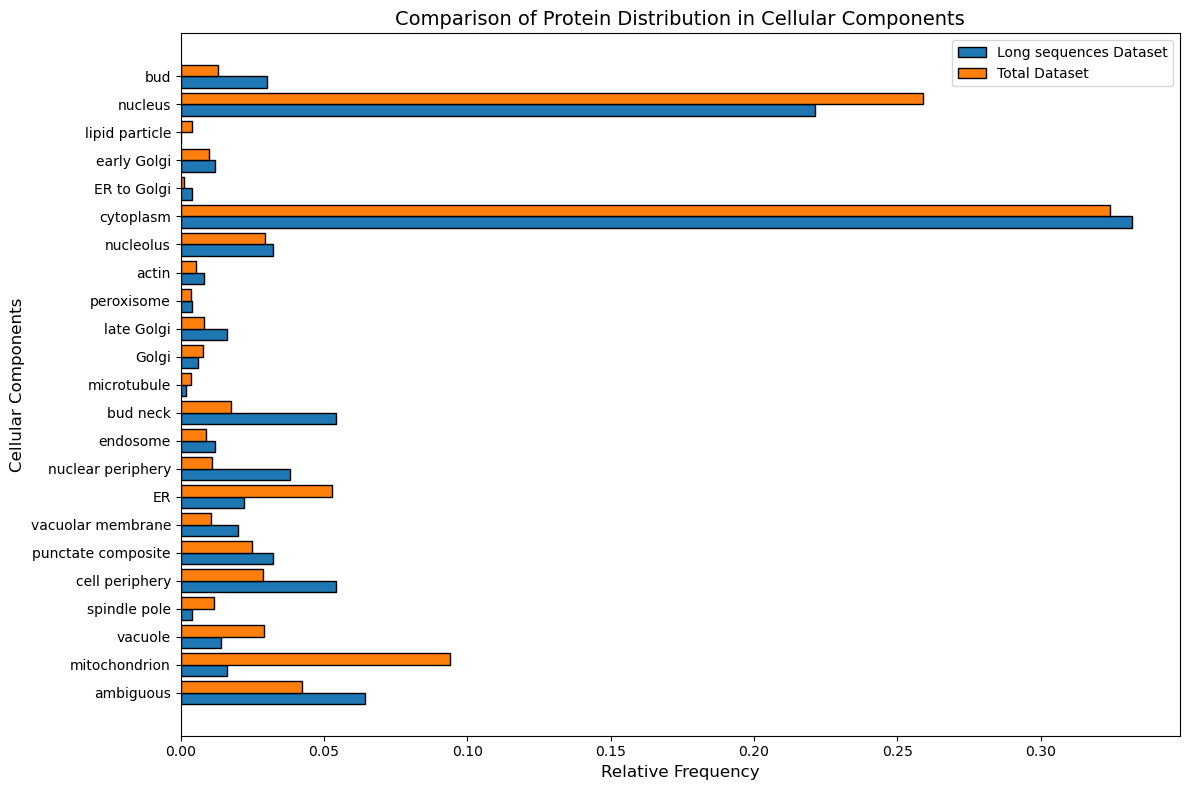

In [123]:
# plot of the comparison of the distributions of all the proteins among the cell and of the onw with long sequences

y_positions = np.arange(len(localizations))
plt.figure(figsize=(12, 8))
bar_width = 0.4
plt.barh(y_positions - bar_width/2, counts, height=bar_width, label='Long sequences Dataset', edgecolor="black")
plt.barh(y_positions + bar_width/2, complete_counts, height=bar_width, label='Total Dataset', edgecolor="black")
plt.yticks(y_positions, localizations)
plt.xlabel("Relative Frequency", fontsize=12)
plt.ylabel("Cellular Components", fontsize=12)
plt.title("Comparison of Protein Distribution in Cellular Components", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

So we can drop these proteins without influencing so much the distribution among the cell.

In [124]:
# Discard too long sequences
static_data_not_long = static_data_sq[~static_data_sq['yORF'].isin(long_sequences)].reset_index(drop=True)
print(len(static_data_not_long))

3772


In [125]:
static_data_not_long

,yORF,ambiguous,mitochondrion,vacuole,spindle pole,cell periphery,punctate composite,vacuolar membrane,ER,nuclear periphery,...,peroxisome,actin,nucleolus,cytoplasm,ER to Golgi,early Golgi,lipid particle,nucleus,bud,Protein Sequence
0,YAL005C,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,MSKAVGIDLGTTYSCVAHFANDRVDIIANDQGNRTTPSFVAFTDTE...
1,YAL007C,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,MIKSTIALPSFFIVLILALVNSVAASSSYAPVAISLPAFSKECLYY...
2,YAL008W,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MTLAFNMQRLVFRNLNVGKRMFKNVPLWRFNVANKLGKPLTRSVGL...
3,YAL009W,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,MEPESIGDVGNHAQDDSASIVSGPRRRSTSKTSSAKNIRNSSNISP...
4,YAL010C,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MLPYMDQVLRAFYQSTHWSTQNSYEDITATSRTLLDFRIPSAIHLQ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,YPR186C,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,MGGEVLNNEGMPLAELKQETIPISRSESSESLNSLTSTRSSSSNRP...
3768,YPR187W,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,MSDYEEAFNDGNENFEDFDVEHFSDEETYEEKPQFKDGETTDANGK...
3769,YPR188C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MDHSESLTFNQLTQDYINKLKDAFQMLDEDEDGLISRGDLTKIYAT...
3770,YPR190C,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,MDELLGEALSAENQTGESTVESEKLVTPEDVMTISSLEQRTLNPDL...


In [128]:
# We export the table as csv
# DA SPOSTARE POST PULIZIA DATASET
output_file_path = 'short_static_data.csv'
static_data_not_long.to_csv(output_file_path, index=False)